In [1]:
import numpy as np
import pandas as pd
import lxml.etree as etree
import sqlite3 as sql
from process import *
import re
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, precision_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [3]:
epl_data = pd.read_csv('../data/prem_data_elo.csv', index_col = 'Unnamed: 0')
epl_data['date'] = epl_data['date'].astype(np.datetime64)

In [7]:
import glob
files = glob.glob('/Users/kayacelebi/Downloads/*.csv')

In [14]:
epl_refs = pd.DataFrame()
for file in files:
    x = pd.read_csv(file)
    epl_refs = pd.concat([epl_refs, x])
epl_refs['Date'] = epl_refs['Date'].astype(np.datetime64)
epl_refs = epl_refs.sort_values(by = 'Date')
epl_refs = epl_refs[['Date', 'Referee', 'HomeTeam', 'AwayTeam']]

In [58]:
print(epl_data.shape)
print(epl_refs.shape)
m_df = pd.merge(epl_data, epl_refs, how = 'inner', left_on = 'date', right_on = 'Date')
m_df['home_team_name'] = m_df['home_team_name'].replace('Manchester City', 'Man-City').replace('Manchester United', 'Man-United').replace(' City', '').replace('Wolverhampton Wanderers', 'Wolves').replace('Queens Park Rangers', 'QPR')
m_df['away_team_name'] = m_df['away_team_name'].replace('Manchester City', 'Man-City').replace('Manchester United', 'Man-United').replace(' City', '').replace('Wolverhampton Wanderers', 'Wolves').replace('Queens Park Rangers', 'QPR')
m_df['HomeTeam'] = m_df['HomeTeam'].replace('Man City', 'Man-City').replace('Man United', 'Man-United')
m_df['AwayTeam'] = m_df['AwayTeam'].replace('Man City', 'Man-City').replace('Man United', 'Man-United')

(2873, 70)
(3420, 4)


In [71]:
s = m_df[m_df.apply(lambda x: x['HomeTeam'] in x['home_team_name'] or x['AwayTeam'] in x['away_team_name'], axis = 1)].drop(['Date', 'HomeTeam', 'AwayTeam', 'home_elo', 'away_elo'], axis = 1)
s.head()

,match_api_id,league_id,date,home_team_api_id,home_team_name,away_team_api_id,away_team_name,home_team_goal,away_team_goal,home_team_foul_reason_from_behind,...,home_team_card_reason_pushing,away_team_card_reason_pushing,home_team_card_reason_diving,away_team_card_reason_diving,home_team_card_reason_hands,away_team_card_reason_hands,home_team_card_reason_Removing Shirt,away_team_card_reason_Removing Shirt,result,Referee
2,658582,1729,2009-08-15,8455,Chelsea,8667,Hull City,2,4,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,L,A Wiley
12,658580,1729,2009-08-15,8462,Portsmouth,9879,Fulham,0,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,M Atkinson
16,658581,1729,2009-08-15,10194,Stoke City,8191,Burnley,2,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,W,S Bennett
31,658575,1729,2009-08-15,10252,Aston Villa,8528,Wigan Athletic,0,8,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,M Clattenburg
33,658579,1729,2009-08-15,8559,Bolton Wanderers,8472,Sunderland,0,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,A Marriner


In [96]:
ref_dict = {}
uni_refs = X['Referee'].sort_values().unique().astype(str)
for i, ref in enumerate(uni_refs):
    ref_dict[ref] = i

In [103]:
s['ref_id'] = [ref_dict[x] for x in s['Referee'].values]

In [148]:
X = s[s.columns[9:]].drop(['result', 'Referee'], axis = 1).reset_index(drop = True)
y = s['result'].reset_index(drop = True)

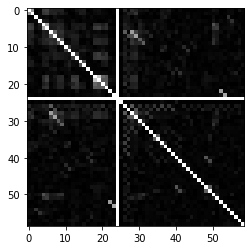

In [124]:
plt.imshow(X.corr().abs().values, cmap = 'gray')
plt.show()

In [146]:
X.shape, np.unique(y, return_counts = True)[1]

((1819, 59), array([ 207, 1083,  529]))

In [149]:
ref_clf, X_train, X_test, y_train, y_test = train_test(RFpipe, X, y, class_labels = ['W', 'L'], weight = True, down_sample = True, return_clf = True)

>>>Preprocess done {'W': 1.0, 'L': 2.047258979206049}
   Class  Accuracy  Precision  Recall   F1  Support
0      W       1.0        1.0     1.0  1.0      423
1      L       1.0        1.0     1.0  1.0      423
2  Total       1.0        1.0     1.0  1.0      846
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.801887   0.801887  0.801887  0.801887      106
1      L  0.801887   0.801887  0.801887  0.801887      106
2  Total  0.801887   0.801887  0.801887  0.801887      212


In [150]:
r = permutation_importance(ref_clf, X_test, y_test, n_repeats = 30)

qual_idx = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] > 0:
        qual_idx += [i]
        print("{feat}\t\t{mean} +/- {std}".format(
            feat = X.columns[i],
            mean = np.round(r.importances_mean[i], 3),
            std = np.round(r.importances_std[i], 3)
        ))

home_team_card_color_y		0.079 +/- 0.022
away_team_card_color_y2		0.016 +/- 0.003
home_team_foul_reason_serious_foul		0.013 +/- 0.005


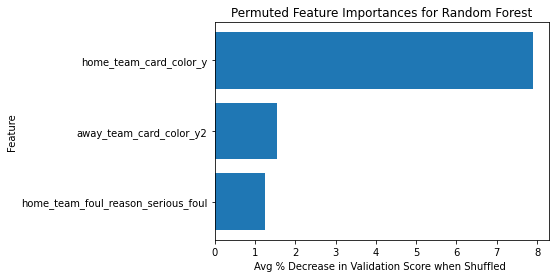

In [151]:
plt.barh(X.columns[qual_idx][::-1], r.importances_mean[qual_idx][::-1]*100)
plt.title('Permuted Feature Importances for Random Forest')
plt.xlabel('Avg % Decrease in Validation Score when Shuffled ')
plt.ylabel('Feature')
#plt.xticks(range(0, 11, 2))
#plt.savefig('feat_imp_rf.png', dpi = 200, bbox_inches='tight')
plt.show()

In [182]:
top_confident_matches = np.argsort(np.apply_along_axis(lambda x: np.abs(x[0] - x[1]), -1, ref_clf.predict_proba(X_test)))[::-1][:10]

In [192]:
top_confident_matches

array([ 42, 171,  65,  31, 108, 203, 136, 182,  56,  92])

In [190]:
X_test.iloc[top_confident_matches]

,home_team_foul_reason_from_behind,away_team_foul_reason_from_behind,home_team_foul_reason_hands,away_team_foul_reason_hands,home_team_foul_reason_pushing,away_team_foul_reason_pushing,home_team_foul_reason_serious_foul,away_team_foul_reason_serious_foul,home_team_foul_reason_shirt_pull,away_team_foul_reason_shirt_pull,...,away_team_card_reason_violence,home_team_card_reason_pushing,away_team_card_reason_pushing,home_team_card_reason_diving,away_team_card_reason_diving,home_team_card_reason_hands,away_team_card_reason_hands,home_team_card_reason_Removing Shirt,away_team_card_reason_Removing Shirt,ref_id
250,1.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1346,1.0,0.0,1.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1525,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14
34,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
147,0.0,3.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,25
1244,1.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
509,0.0,5.0,0.0,0.0,4.0,3.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
964,2.0,2.0,0.0,0.0,4.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
964,2.0,2.0,0.0,0.0,4.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10


In [191]:
pred = ref_clf.predict(X_test.iloc[top_confident_matches])

In [193]:
conf_matches = s.reset_index(drop=True).iloc[X_test.iloc[top_confident_matches].index]
conf_matches['pred'] = (conf_matches['result'] == pred)

In [194]:
conf_matches

,match_api_id,league_id,date,home_team_api_id,home_team_name,away_team_api_id,away_team_name,home_team_goal,away_team_goal,home_team_foul_reason_from_behind,...,home_team_card_reason_diving,away_team_card_reason_diving,home_team_card_reason_hands,away_team_card_reason_hands,home_team_card_reason_Removing Shirt,away_team_card_reason_Removing Shirt,result,Referee,ref_id,pred
250,659081,1729,2010-02-21,8655,Blackburn Rovers,8559,Bolton Wanderers,3,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,W,C Foy,3,True
1346,1724001,1729,2014-08-24,8586,Tottenham Hotspur,10172,QPR,4,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,W,A Taylor,1,True
1525,1724264,1729,2015-03-15,8455,Chelsea,8466,Southampton,1,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,L,M Dean,14,True
34,658613,1729,2009-09-12,8650,Liverpool,8191,Burnley,4,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,W,L Mason,10,True
147,658822,1729,2009-12-12,8586,Tottenham Hotspur,8602,Wolves,0,2,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,L,S Attwell,25,True
1244,1474936,1729,2014-01-28,8650,Liverpool,8668,Everton,4,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,W,M Atkinson,12,True
509,840086,1729,2011-01-22,9825,Arsenal,8528,Wigan Athletic,3,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,W,K Friend,8,True
964,1229305,1729,2012-12-26,8472,Sunderland,8456,Man-City,1,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,W,K Friend,8,True
964,1229305,1729,2012-12-26,8472,Sunderland,8456,Man-City,1,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,W,K Friend,8,True
188,658935,1729,2009-12-30,10260,Man-United,8528,Wigan Athletic,5,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,W,L Mason,10,True


In [247]:
tr = ref_clf['rf'].estimators_[0]
val, count = np.unique(tr.apply(X_test.values), return_counts= True)
sorted(zip(val, count), key = lambda x: x[1])[::-1][:10]

[(382, 150),
 (383, 15),
 (415, 10),
 (418, 9),
 (417, 8),
 (343, 3),
 (378, 2),
 (359, 2),
 (341, 2),
 (339, 2)]

In [248]:
# Find samples in X_test where leaf is 382, most samples visit it
big_leaf_idx = np.where(tr.apply(X_test.values) == 382)[0]
X_test.iloc[big_leaf_idx]

,home_team_foul_reason_from_behind,away_team_foul_reason_from_behind,home_team_foul_reason_hands,away_team_foul_reason_hands,home_team_foul_reason_pushing,away_team_foul_reason_pushing,home_team_foul_reason_serious_foul,away_team_foul_reason_serious_foul,home_team_foul_reason_shirt_pull,away_team_foul_reason_shirt_pull,...,away_team_card_reason_violence,home_team_card_reason_pushing,away_team_card_reason_pushing,home_team_card_reason_diving,away_team_card_reason_diving,home_team_card_reason_hands,away_team_card_reason_hands,home_team_card_reason_Removing Shirt,away_team_card_reason_Removing Shirt,ref_id
1002,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
296,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3
454,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22
382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,13
912,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17
1012,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1023,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,6
330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,11


In [273]:
for c in [0]:
    tr = ref_clf['rf'].estimators_[c]
    node_indicator = tr.decision_path(X.values)
    leaf_id = tr.apply(X.values)
    n_nodes = tr.tree_.node_count
    children_left = tr.tree_.children_left
    children_right = tr.tree_.children_right
    feature = tr.tree_.feature
    threshold = tr.tree_.threshold

    sample_id = 1002
    # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
    node_index = node_indicator.indices[
        node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
    ]

    print("Rules used to predict sample {id}:\n".format(id=sample_id))
    for node_id in node_index:
        # continue to the next node if it is a leaf node
        #if leaf_id[sample_id] == node_id:
        #    continue

        # check if value of the split feature for sample 0 is below threshold
        if X.values[sample_id, feature[node_id]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print(
            "decision node {node} : {feature}[{sample}] = {value}) "
            "{inequality} {threshold})".format(
                node=node_id,
                sample=sample_id,
                feature=X.columns[feature[node_id]],
                value=ref_clf['scaler'].inverse_transform(X.values[sample_id].reshape(1, -1))[:, feature[node_id]],
                inequality=threshold_sign,
                threshold=np.round(threshold[node_id],1),
            )
        )
    print("Prediction: %s" % (np.array(['L', 'W'])[tr.predict(X.values[sample_id].reshape(1, -1)).astype(int)]))

Rules used to predict sample 1002:

decision node 0 : home_team_card_color_r[1002] = [0.09219858]) <= 2.2)
decision node 1 : home_team_foul_reason_pushing[1002] = [8.23194475]) > -0.2)
decision node 257 : home_team_foul_reason_penalty[1002] = [0.16312057]) <= 2.4)
decision node 258 : away_team_foul_reason_obstruction[1002] = [0.29905437]) <= 0.2)
decision node 259 : ref_id[1002] = [81.69172675]) > 1.7)
decision node 381 : away_team_foul_reason_shirt_pull[1002] = [0.3108747]) <= 1.3)
decision node 382 : away_team_card_reason_Removing Shirt[1002] = [0.01654846]) > -2.0)
Prediction: ['W']


In [265]:
ref_clf['scaler'].inverse_transform(X.values[250].reshape(1, -1))

array([[3.94787499e+00, 1.03379457e+01, 6.54846336e-01, 7.93144208e-01,
        2.03191489e+00, 2.34633570e+00, 8.47517730e-01, 2.61470191e+00,
        2.76595745e-01, 3.10874704e-01, 1.28841608e-01, 1.33569740e-01,
        3.91252955e-01, 4.72813239e-01, 1.91489362e-01, 2.99054374e-01,
        1.63120567e-01, 2.89598109e-01, 2.04137116e+00, 1.92080378e+00,
        5.00000000e-01, 5.76832151e-01, 4.49172577e-02, 3.42789598e-02,
        0.00000000e+00, 0.00000000e+00, 2.85342790e+00, 8.54946138e+00,
        6.59574468e-01, 4.18711599e+00, 5.91016548e-02, 1.06382979e-01,
        4.96453901e-02, 8.03782506e-02, 3.64066194e-01, 5.05910165e-01,
        1.72576832e-01, 1.67848700e-01, 7.56501182e-02, 1.51300236e-01,
        9.21985816e-02, 1.46572104e-01, 5.67375887e-02, 6.61938534e-02,
        4.49172577e-02, 4.01891253e-02, 3.30969267e-02, 6.85579196e-02,
        3.78250591e-02, 4.25531915e-02, 4.25531915e-02, 5.43735225e-02,
        4.72813239e-02, 4.96453901e-02, 4.01891253e-02, 5.673758

In [221]:
dec_tree_res = [np.mean((ref_clf['rf'].classes_[x.predict(X_test.loc[250].values.reshape(1, -1)).astype(int)]) == y_test.loc[250]) for x in tqdm(ref_clf['rf'].estimators_)]

  0%|          | 0/100 [00:00<?, ?it/s]

In [233]:
#ref_clf['rf'].estimators_[0].predict(X_test)
np.where(np.array(dec_tree_res) == 1)

(array([ 0,  4,  5,  7,  8, 10, 11, 12, 17, 20, 22, 24, 28, 29, 30, 31, 36,
        37, 38, 39, 41, 42, 43, 44, 47, 50, 53, 54, 56, 57, 58, 61, 62, 63,
        64, 66, 67, 68, 69, 72, 77, 83, 84, 86, 87, 89, 90, 92, 96, 97, 98,
        99]),)

In [252]:
from sklearn.linear_model import PoissonRegressor

In [261]:
pois_clf = PoissonRegressor().fit(X_train, [0 if x == 'L' else 1 for x in y_train])

In [260]:
np.mean(np.array(['L', 'W'])[np.round(pois_clf.predict(X_test), 0).astype(int)] == y_test)

0.6415094339622641

In [275]:
train_test(RFpipe(params = {'min_samples_split':20}), X, y, weight = True, down_sample = True, class_labels = ['W', 'L'])

>>>Preprocess done {'W': 1.0, 'L': 2.047258979206049}


TypeError: 'Pipeline' object is not callable